In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

## Transforms
To see all examples of transforms, check out official documentation - https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
}

In [4]:
data_dir = '../datasets/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train', 'val']}

In [5]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 244
     Root location: datasets/hymenoptera_data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root location: datasets/hymenoptera_data/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
            )}

In [6]:
dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 8, shuffle=True, num_workers = 4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

In [7]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [8]:
device

device(type='mps')

## Visualizing a few images

In [9]:
def imshow(inputs, title=None):
    inputs = inputs.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inputs = std * inputs + mean
    inputs = np.clip(inputs, 0, 1)
    plt.imshow(inputs)
    if title:
        plt.title(title)

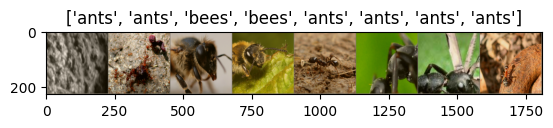

In [10]:
inputs, labels = next(iter(dataloader['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in labels])

In [11]:
inputs.size(0)

8

In [12]:
print(labels.data)
print(labels)

tensor([0, 0, 1, 1, 0, 0, 0, 0])
tensor([0, 0, 1, 1, 0, 0, 0, 0])


In [13]:
dataset_sizes

{'train': 244, 'val': 153}

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    tic = time.time()

    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-'*10)

        # Each epoch has a training and a validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train() # Sets model to training mode
            else:
                model.eval() # Sets model to eval mode
            
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                # forward pass
                # Track history only if train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward pass + optimize ONLY if train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item()*inputs.size(0) # Multiply loss by batch size
                running_corrects += torch.sum(labels.data == preds)

            if phase == 'train':
                scheduler.step() # Learning Rate update
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.item() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # deep copy the model
            if phase == 'val' and epoch_acc>best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - tic
    print(f'Training time completed in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val accuracy = {best_acc:.4f}')

    #loading best model weights
    model.load_state_dict(best_model_weights)
    return(model)

## Visualization
`model.training` variable is a `nn.Module` class attribute, set as -
- `True` by `model.train()`
- `False` by `model.eval()`

In [15]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval() 
    # sets model.training to False
    # now model is in evaluation mode

    images_so_far = 0
    fig = plt.figure(figsize=(20,10))

    with torch.no_grad():
        for i,(inputs,labels) in enumerate(dataloader['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]): # Batch size
                images_so_far+=1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode = was_training) # Set to the mode it was in, before calling this function
                    return
        model.train(mode = was_training)

In [10]:
model_ft = models.resnet152(pretrained = True)
num_features = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_features, 2) # Adding a last fully connected layer for our purpose
model_ft = model_ft.to(device)

In [7]:
from torchsummary import summary

In [8]:
summary(model_ft, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.5487 Acc: 0.7254
val Loss: 0.1842 Acc: 0.9281

Epoch 2/25
----------
train Loss: 0.2881 Acc: 0.8689
val Loss: 0.1135 Acc: 0.9477

Epoch 3/25
----------
train Loss: 0.2369 Acc: 0.8975
val Loss: 0.2096 Acc: 0.9216

Epoch 4/25
----------
train Loss: 0.2210 Acc: 0.9262
val Loss: 0.1185 Acc: 0.9608

Epoch 5/25
----------
train Loss: 0.2036 Acc: 0.9016
val Loss: 0.0904 Acc: 0.9608

Epoch 6/25
----------
train Loss: 0.1003 Acc: 0.9590
val Loss: 0.1137 Acc: 0.9608

Epoch 7/25
----------
train Loss: 0.1215 Acc: 0.9631
val Loss: 0.0977 Acc: 0.9608

Epoch 8/25
----------
train Loss: 0.1288 Acc: 0.9590
val Loss: 0.0873 Acc: 0.9739

Epoch 9/25
----------
train Loss: 0.1675 Acc: 0.9262
val Loss: 0.0901 Acc: 0.9739

Epoch 10/25
----------
train Loss: 0.0838 Acc: 0.9631
val Loss: 0.0872 Acc: 0.9673

Epoch 11/25
----------
train Loss: 0.2014 Acc: 0.9221
val Loss: 0.0837 Acc: 0.9673

Epoch 12/25
----------
train Loss: 0.0879 Acc: 0.9754
val Loss: 0.0860 Acc: 0.9673

E

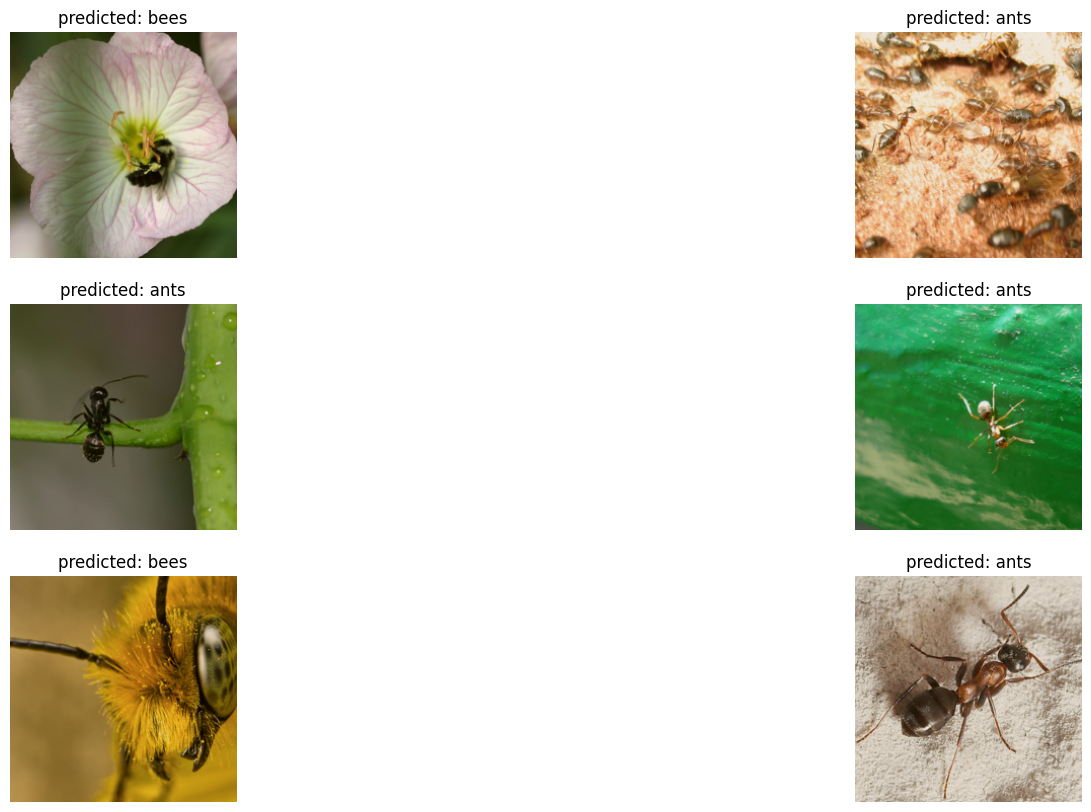

In [19]:
visualize_model(model_ft)

plt.ioff()
plt.show()

In [19]:
#torch.save(model_ft, 'models/hymenoptera_resnet-152_full_train.pt')

# ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need to set `requires_grad = False` to freeze the parameters so that the gradients are not computed in `backward()`

In [21]:
model_conv = torchvision.models.resnet152(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = torch.optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.5460 Acc: 0.7172
val Loss: 0.2389 Acc: 0.9216

Epoch 2/25
----------
train Loss: 0.3419 Acc: 0.8607
val Loss: 0.1745 Acc: 0.9346

Epoch 3/25
----------
train Loss: 0.2825 Acc: 0.8893
val Loss: 0.1479 Acc: 0.9542

Epoch 4/25
----------
train Loss: 0.2812 Acc: 0.8607
val Loss: 0.1699 Acc: 0.9346

Epoch 5/25
----------
train Loss: 0.2767 Acc: 0.8811
val Loss: 0.1283 Acc: 0.9477

Epoch 6/25
----------
train Loss: 0.2721 Acc: 0.8689
val Loss: 0.1311 Acc: 0.9477

Epoch 7/25
----------
train Loss: 0.2759 Acc: 0.8852
val Loss: 0.1201 Acc: 0.9542

Epoch 8/25
----------
train Loss: 0.2671 Acc: 0.8811
val Loss: 0.1202 Acc: 0.9346

Epoch 9/25
----------
train Loss: 0.2112 Acc: 0.9221
val Loss: 0.1096 Acc: 0.9608

Epoch 10/25
----------
train Loss: 0.2471 Acc: 0.8770
val Loss: 0.1133 Acc: 0.9673

Epoch 11/25
----------
train Loss: 0.2138 Acc: 0.9098
val Loss: 0.1140 Acc: 0.9542

Epoch 12/25
----------
train Loss: 0.1587 Acc: 0.9303
val Loss: 0.1200 Acc: 0.9608

E

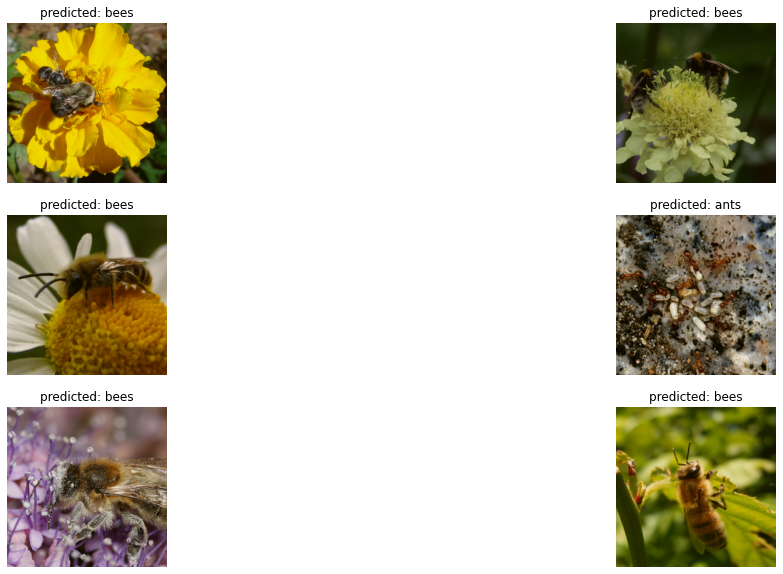

In [23]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [24]:
#torch.save(model_conv, 'models/hymenoptera_resnet-152_last_layer_train.pt')